In [1]:
%cd ../src

/home/edvard/Workspace/tgraphnet/src


In [2]:
%ls

angles/  data/        features/  loss/    vizualization/
common/  evaluation/  graph/     models/


In [3]:
import os
from common.utils import Params, set_logger, copy_weight, load_checkpoint, save_checkpoint_pos_ori, write_log, get_lr, write_train_summary_scalars, write_val_summary_joint, change_momentum
from features.networks import TGraphNet, TGraphNetSeq
from vizualization.vizualize import plot_adjacency_matrix, plot_pose_animation, plot_poses_only
from common.h36m_skeleton import get_node_names, get_edge_names
import torch
from graph import Graph
import numpy as np

from data.h36m_dataset import Human36M
from data.pw3d_dataset import PW3D
from common.h36m_skeleton import joint_id_to_names
from data.generators import ChunkedGenerator_Seq, UnchunkedGenerator_Seq, ChunkedGenerator_Frame, ChunkedGenerator_Seq2Seq, eval_data_prepare

/home/edvard/Workspace/env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# Load parameters
json_path = os.path.join('../models/stgcn/run11/params.json')
assert os.path.isfile(json_path), "No json file found at {}".format(json_path)
params = Params(json_path)

In [28]:
checkpoint = torch.load('../models/stgcn/run11/best_pos.pth.tar')

In [29]:
checkpoint['state_dict'].keys()

odict_keys(['adj_v', 'adj_e', 'downsample_layers.0.adj_v', 'downsample_layers.0.adj_e', 'downsample_layers.0.graph_stages.0.gcn.weight', 'downsample_layers.0.graph_stages.0.gcn.bias', 'downsample_layers.0.graph_stages.0.gcn.norm.weight', 'downsample_layers.0.graph_stages.0.gcn.norm.bias', 'downsample_layers.0.graph_stages.0.gcn.norm.running_mean', 'downsample_layers.0.graph_stages.0.gcn.norm.running_var', 'downsample_layers.0.graph_stages.0.gcn.norm.num_batches_tracked', 'downsample_layers.0.graph_stages.0.tcn.0.weight', 'downsample_layers.0.graph_stages.0.tcn.0.bias', 'downsample_layers.0.graph_stages.0.tcn.1.weight', 'downsample_layers.0.graph_stages.0.tcn.1.bias', 'downsample_layers.0.graph_stages.0.tcn.1.running_mean', 'downsample_layers.0.graph_stages.0.tcn.1.running_var', 'downsample_layers.0.graph_stages.0.tcn.1.num_batches_tracked', 'downsample_layers.0.graph_stages.0.residual_gc.weight', 'downsample_layers.0.graph_stages.0.residual_gc.bias', 'downsample_layers.0.graph_stages.0

In [30]:
model = TGraphNetSeq(infeat_v=params.input_node_feat,
                  infeat_e=params.input_edge_feat,
                  nhid_v=params.num_hidden_nodes,
                  nhid_e=params.num_hidden_edges,
                  n_oute=params.output_edge_feat,
                  n_outv=params.output_node_feat,
                  gcn_window=params.gcn_window,
                  tcn_window=params.tcn_window,
                  in_frames=params.in_frames,
                  gconv_stages=params.gconv_stages,
                  num_groups=params.num_groups,
                  dropout=params.dropout,
                  aggregate=params.aggregate,
                  use_residual_connections=params.use_residual_connections,
                  use_non_parametric=params.use_non_parametric,
                  use_edge_conv=params.use_edge_conv,
                  learn_adj=False)

load_checkpoint('../models/stgcn/run11/best_pos.pth.tar', model)

{'epoch': 7,
 'state_dict': OrderedDict([('adj_v',
               tensor([[[ 0.2927,  0.1374, -0.0238,  ..., -0.0138,  0.0160, -0.0216],
                        [ 0.0291,  0.3699, -0.0258,  ...,  0.0038, -0.0172, -0.0109],
                        [-0.0282, -0.1107,  0.5685,  ..., -0.0240, -0.0011,  0.0038],
                        ...,
                        [-0.0313, -0.0751, -0.0171,  ...,  0.4509, -0.0455,  0.0087],
                        [-0.0270, -0.1240, -0.0111,  ...,  0.0312,  0.5299, -0.0193],
                        [-0.0365, -0.0955, -0.0120,  ..., -0.0353, -0.0087,  0.6114]],
               
                       [[-0.0208,  0.0488, -0.0530,  ...,  0.0819,  0.0576,  0.0212],
                        [ 0.1304,  0.0160, -0.1057,  ...,  0.0078, -0.0271, -0.0225],
                        [-0.0022,  0.2347, -0.1246,  ..., -0.0463, -0.0198, -0.0133],
                        ...,
                        [-0.0037, -0.0187, -0.0155,  ...,  0.0186, -0.1292, -0.0637],
              

In [8]:
model.state_dict().keys()

odict_keys(['adj_v', 'adj_e', 'downsample_layers.0.adj_v', 'downsample_layers.0.adj_e', 'downsample_layers.0.graph_stages.0.gcn.weight', 'downsample_layers.0.graph_stages.0.gcn.bias', 'downsample_layers.0.graph_stages.0.gcn.norm.weight', 'downsample_layers.0.graph_stages.0.gcn.norm.bias', 'downsample_layers.0.graph_stages.0.gcn.norm.running_mean', 'downsample_layers.0.graph_stages.0.gcn.norm.running_var', 'downsample_layers.0.graph_stages.0.gcn.norm.num_batches_tracked', 'downsample_layers.0.graph_stages.0.tcn.0.weight', 'downsample_layers.0.graph_stages.0.tcn.0.bias', 'downsample_layers.0.graph_stages.0.tcn.1.weight', 'downsample_layers.0.graph_stages.0.tcn.1.bias', 'downsample_layers.0.graph_stages.0.tcn.1.running_mean', 'downsample_layers.0.graph_stages.0.tcn.1.running_var', 'downsample_layers.0.graph_stages.0.tcn.1.num_batches_tracked', 'downsample_layers.0.graph_stages.0.residual_gc.weight', 'downsample_layers.0.graph_stages.0.residual_gc.bias', 'downsample_layers.0.graph_stages.0

In [ ]:
plot_adjacency_matrix(model.state_dict()['adj_v'][0].cpu(), node_names=get_node_names(3), annotate_values=True)

# Plotting Predicted 3D Poses

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
test_dataset = Human36M(data_dir="/media/HDD3/datasets/Human3.6M/pose_zip", train=False, ds_category=params.ds_category, actions='WalkDog')
# test_dataset = PW3D(data_file="../data/pw3d_test.pkl", actions=['downtown_runForBus_01_0'])

Subjects:  [9, 11] cpn
2d:  8 3d:  8 angles_6d:  8 edge_feat: 8 global_ori:  8 camera params 8
14688


/home/edvard/Workspace/tgraphnet/src/angles/rotations.py:475: RuntimeWarning: invalid value encountered in true_divide
  vector_u = vector / np.linalg.norm(vector, axis=1).reshape(-1,1)


In [9]:
cam, pos2d, pos3d, angles_6d, edge_features = test_dataset.cam, test_dataset.pos2d, test_dataset.pos3d_centered, [], []
val_generator = ChunkedGenerator_Seq2Seq(params.batch_size, cameras=cam, poses_2d=pos2d, poses_3d=pos3d,
                                                   chunk_length=31, pad=25, out_all=True, shuffle=False,
                                                   augment=False, reverse_aug=False,)

In [32]:
model.to(device)
None

In [33]:
from matplotlib.animation import PillowWriter, FFMpegWriter

In [34]:
gt_pos3d = np.empty([0, 17, 3])
pred_pose3d = np.empty([0, 17, 3])

i_batch = 0

with torch.no_grad():
    for cameras_val, batch_3d, batch_6d, batch_2d, batch_edge in val_generator.next_epoch():
        input_2d = torch.FloatTensor(batch_2d).to(device)
        target_pose_3d = torch.FloatTensor(batch_3d).to(device)
        cameras_val = torch.from_numpy(cameras_val.astype('float32')).to(device)

        middle_index = int((target_pose_3d.shape[1] - 1) / 2)
        pad = 15
        start_index = middle_index - pad
        end_index = middle_index + pad + 1
        B, T, J, D = target_pose_3d.shape

        predicted_pos3d = model(input_2d)
        predicted_pos3d_center = predicted_pos3d[:, start_index:end_index].reshape(B, (2 * pad + 1), J, D).cpu().data.numpy()
        print(predicted_pos3d_center.shape)

        # target_angle_6d = target_angle_6d[:, middle_index].view_as(predicted_angle_6d)
        target_pose_3d = target_pose_3d.view_as(predicted_pos3d)
        target_pose_3d_center = target_pose_3d[:, start_index:end_index].reshape(B, (2 * pad + 1), J, D).cpu().data.numpy()

        target_pose_3d_center[:, :, :1] = 0
        predicted_pos3d_center[:, :, :1] = 0
        target_pose_3d_center[:, :, 1:] += target_pose_3d_center[:, :, :1]
        predicted_pos3d_center[:, :, 1:] += predicted_pos3d_center[:, :, :1]

        if i_batch == 0:
            gt_pos3d = target_pose_3d_center.reshape(-1, J, D)
            pred_pose3d = predicted_pos3d_center.reshape(-1, J, D)
            # mpjpe_err = _mpjpe
        else:
            gt_pos3d = np.concatenate((gt_pos3d, target_pose_3d_center.reshape(-1, J, D)), axis=0)
            pred_pose3d = np.concatenate((pred_pose3d, predicted_pos3d_center.reshape(-1, J, D)), axis=0)
            print(pred_pose3d.shape)
            # mpjpe_err = np.concatenate((mpjpe_err,_mpjpe), axis=0)
            print(i_batch, gt_pos3d.shape, pred_pose3d.shape)

        i_batch += 1

(64, 31, 17, 3)
(64, 31, 17, 3)
(3968, 17, 3)
1 (3968, 17, 3) (3968, 17, 3)
(64, 31, 17, 3)
(5952, 17, 3)
2 (5952, 17, 3) (5952, 17, 3)
(64, 31, 17, 3)
(7936, 17, 3)
3 (7936, 17, 3) (7936, 17, 3)
(64, 31, 17, 3)
(9920, 17, 3)
4 (9920, 17, 3) (9920, 17, 3)
(64, 31, 17, 3)
(11904, 17, 3)
5 (11904, 17, 3) (11904, 17, 3)
(64, 31, 17, 3)
(13888, 17, 3)
6 (13888, 17, 3) (13888, 17, 3)
(32, 31, 17, 3)
(14880, 17, 3)
7 (14880, 17, 3) (14880, 17, 3)


In [35]:
scale = 30

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pytransform3d import rotations as pr
from pytransform3d.plot_utils import make_3d_axis
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.transforms import Affine2D
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from common.h36m_skeleton import *
from matplotlib.animation import FuncAnimation

def plot_pose_animation(pred_pos3d, gt_pos3d, mpjpe_err=None, action="", num_frames=81, save_path=None):
    assert save_path is not None

    fig = plt.figure(figsize=(12, 12))
    ax = make_3d_axis(20, pos=int('11{}'.format(1)), n_ticks=5,)

    def animate(i):
        ax.clear()
        pred_pos = pred_pos3d[i]
        gt_pos = gt_pos3d[i]
        pos_err = mpjpe_err[i] if mpjpe_err is not None else 0
        ax.view_init(-80, 90) # view them from front
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")
        ax.set_ylim(-scale, scale)
        ax.set_xlim(-scale, scale)
        ax.set_zlim(-scale, scale)

        plot_poses_only(gt_pos, pred_pos, "", pos_err, ax=ax, x_offset=-20, y_offset=-14)

    ani = FuncAnimation(fig, animate, frames=num_frames, repeat=False, interval=10) #interval: Delay between frames in milliseconds

    return ani

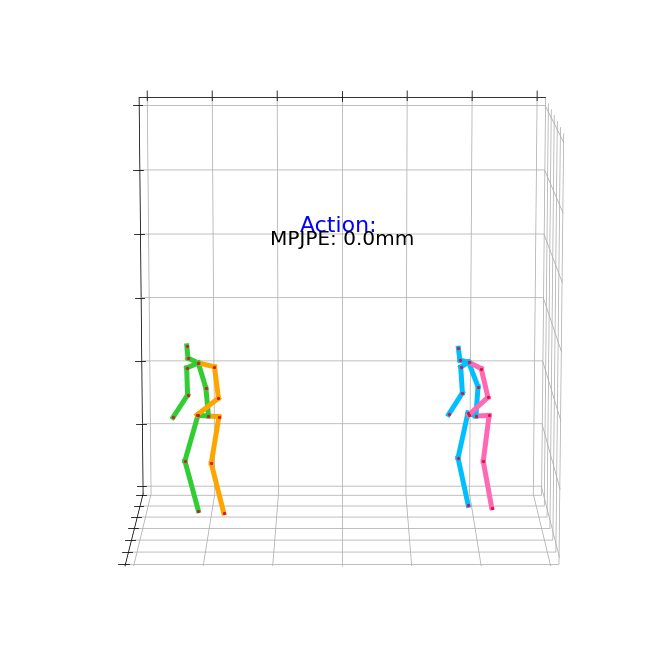

In [36]:
anim = plot_pose_animation(pred_pose3d, gt_pos3d=gt_pos3d, save_path="", num_frames=775)
anim.save("../reports/walkdog_h36m_64_1block_woglobal.gif", dpi=50, writer=PillowWriter(fps=24))